In [1]:
import pandas as pd
import geopandas as gpd
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx
import glob

In [2]:
data_filenames = glob.glob('*.csv')
data_filenames = data_filenames[0]
df_pop = pd.read_csv(data_filenames)

In [3]:
df_pop.rename(columns={'COL0': 'GEO_UID','COL1': 'Pop16', 'COL2': 'Avg_HH_Size', 'COL3': 'LowIncTot', 'COL4': 'Housing_Tot', 'COL5': 'Owner_Tot', 'COL6': 'Renter_Tot', 'COL7': 'Avg_Num_Rooms', 'COL8': 'Housing_Suit_Tot', 'COL9': 'Suitable_Tot', 'COL10': 'Not_Suitable_Tot', 'COL11': 'DwellCon_Tot', 'COL12': 'DwellCon_1', 'COL13': 'DwellCon_2', 'COL14': 'HH_Inc_Tot', 'COL15': 'HH_Inc_Below30', 'COL16': 'HH_Inc_Above30', 'COL17': 'HHOwner_Inc', 'COL18': 'HHOwner_%Mortgage', 'COL19': 'HHOwner_Above30', 'COL20': 'HHOwner_Avg_Cost', 'COL21': 'HHTenant_Inc', 'COL22': 'HHTenant_Subsd', 'COL23': 'HHTenant_Above30', 'COL24': 'HHTenant_Avg_Cost'}, inplace = True)
df_pop['LowIncPerc'] = df_pop['LowIncTot'] / df_pop['Pop16'] * 100

In [4]:
geoms_filenames = glob.glob('*.shp')
geoms_filename = geoms_filenames[0]
gdf_da = gpd.read_file(geoms_filename)

In [5]:
to_convert = {'DAUID': 'int64'}
gdf_da = gdf_da.astype(to_convert)

In [23]:
merged_gdf = pd.merge(gdf_da, df_pop, how = 'inner', left_on = 'DAUID', right_on = 'GEO_UID')
final_gdf = merged_gdf.to_crs('EPSG:2950')

In [20]:
final_gdf.to_file('FILENAME.geojson', driver='GeoJSON')
gjsonFiles = glob.glob('*.geojson')
gdf_da = gpd.read_file(gjsonFiles[1])
gdf_muni = gpd.read_file(gjsonFiles[0])

In [21]:
gdf_muni = gdf_muni.to_crs('EPSG:2950')
gdf_da = gdf_da.fillna(0)

In [22]:
gdf_da['centroids'] = gdf_da['geometry'].centroid
gdf_da.set_geometry('centroids', inplace=True)
gdf_da.rename(columns={"geometry": "polygons"}, inplace=True)
gdf_da_sjoined = gdf_da.sjoin(gdf_muni, how='left')
gdf_da_sjoined.set_geometry('polygons', inplace=True)

In [10]:
sum_stats = gdf_da_sjoined.dissolve('NOM', 'sum')
sum_stats['LowIncPerc'] = sum_stats['LowIncTot']/sum_stats['Pop16']*100
mean_stats = gdf_da_sjoined.dissolve('NOM', 'mean')
sum_stats = sum_stats.fillna(0)
mean_stats = mean_stats.fillna(0)

In [11]:
def total(gdf):
    result = gdf.sum()
    return result

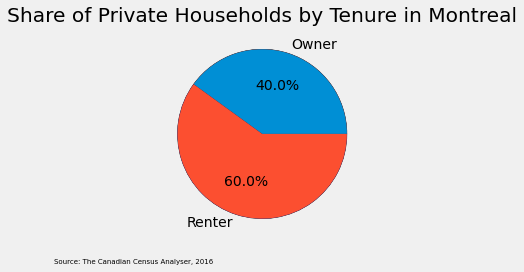

In [12]:
plt.style.use('fivethirtyeight')

slices = [total(gdf_da_sjoined['Owner_Tot']) / total(gdf_da_sjoined['Housing_Tot']), total(gdf_da_sjoined['Renter_Tot']) / total(gdf_da_sjoined['Housing_Tot'])]
labels = ['Owner', 'Renter']
colors = ['red', 'blue']

plt.pie(slices, labels=labels, colors=colors, autopct='%1.1f%%', wedgeprops = {'edgecolor':'black'})

plt.pie(slices)

plt.annotate('Source: The Canadian Census Analyser, 2016', (-0.2,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

plt.title('Share of Private Households by Tenure in Montreal')
plt.tight_layout()
plt.show()

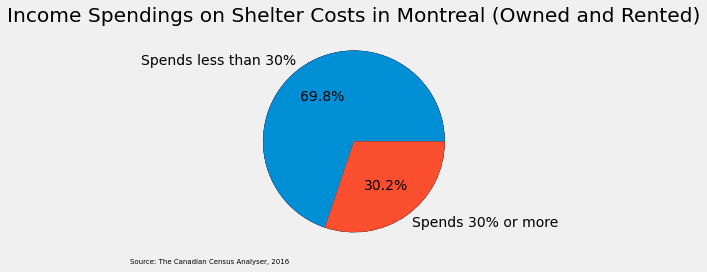

In [13]:
plt.style.use('fivethirtyeight')

slices = [total(gdf_da_sjoined['HH_Inc_Below30']) / total(gdf_da_sjoined['HH_Inc_Tot']), total(gdf_da_sjoined['HH_Inc_Above30']) / total(gdf_da_sjoined['HH_Inc_Tot'])]
labels = ['Spends less than 30%', 'Spends 30% or more']
colors = ['blue', 'red']

plt.pie(slices, labels=labels, colors=colors, autopct='%1.1f%%', wedgeprops = {'edgecolor':'black'})

plt.pie(slices)

plt.annotate('Source: The Canadian Census Analyser, 2016', (-0.4,0), (-20,-10), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

plt.title('Income Spendings on Shelter Costs in Montreal (Owned and Rented)')
plt.tight_layout()
plt.show()

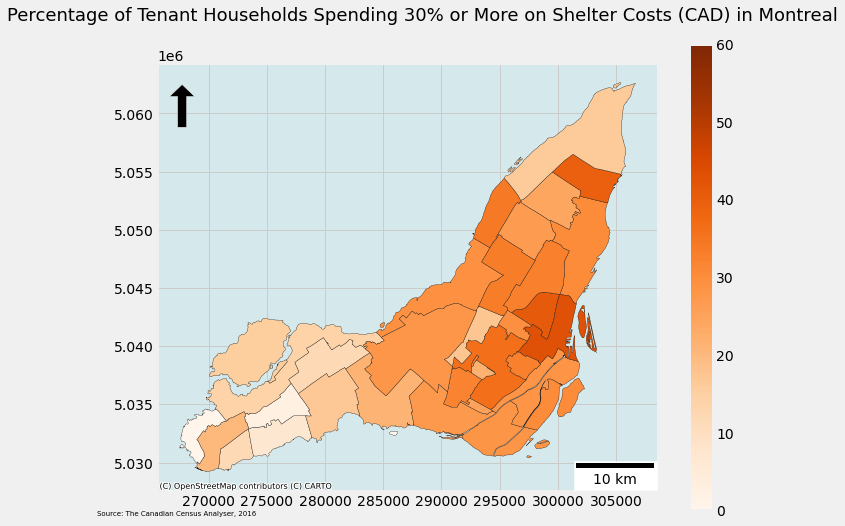

In [17]:
ax = mean_stats.plot(
    'HHTenant_Above30'
    ,figsize=(10,10)
    ,edgecolor="black"
    ,linewidth=0.3
    ,vmax=60
    ,vmin=0
    ,legend=True
    ,legend_kwds= {'shrink':0.8}
    ,cmap="Oranges"
)

ax.annotate(
    "Percentage of Tenant Households Spending 30% or More on Shelter Costs (CAD) in Montreal",
    (0.53,1.09)
    ,xycoords = 'axes fraction'
    ,horizontalalignment='center'
    ,verticalalignment='bottom'
    ,fontsize = 18
    ,color='#000'
    ,fontstyle='normal'
)

plt.annotate('Source: The Canadian Census Analyser, 2016', (0,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)

background = db.query("city_id == 'ci122'")
cx.add_basemap(ax,
               crs=background.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

x, y, arrow_length = 0.05, 0.95, 0.1

ax.annotate('',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=9, headwidth=25),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

scalebar = ScaleBar(1.5, dimension = 'si-length', units = 'm', location = 'lower right')

plt.gca().add_artist(scalebar)

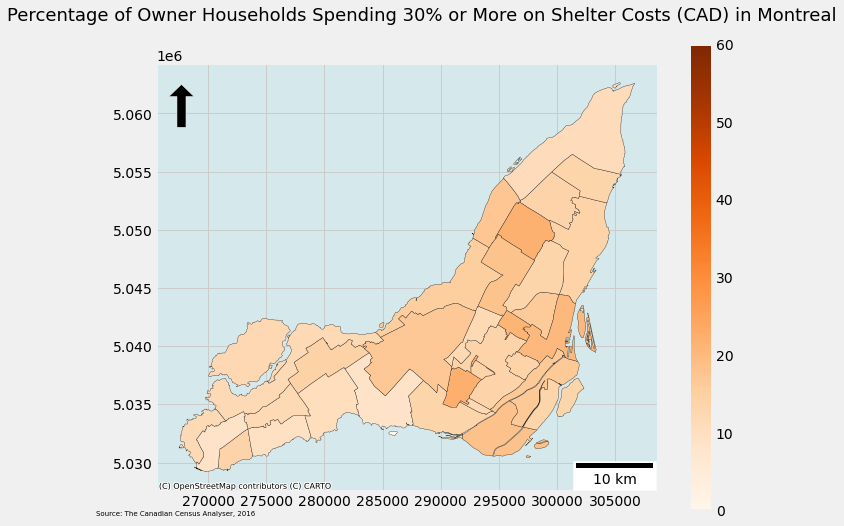

In [16]:
ax = mean_stats.plot(
    'HHOwner_Above30'
    ,figsize=(10,10)
    ,edgecolor="black"
    ,linewidth=0.3
    ,vmax=60
    ,vmin=0
    ,legend=True
    ,legend_kwds= {'shrink':0.8}
    ,cmap="Oranges"
)

ax.annotate(
    "Percentage of Owner Households Spending 30% or More on Shelter Costs (CAD) in Montreal",
    (0.53,1.09)
    ,xycoords = 'axes fraction'
    ,horizontalalignment='center'
    ,verticalalignment='bottom'
    ,fontsize = 18
    ,color='#000'
    ,fontstyle='normal'
)

plt.annotate('Source: The Canadian Census Analyser, 2016', (0,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)

background = db.query("city_id == 'ci122'")
cx.add_basemap(ax,
               crs=background.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=9, headwidth=25),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

scalebar = ScaleBar(1.5, dimension = 'si-length', units = 'm', location = 'lower right')

plt.gca().add_artist(scalebar)

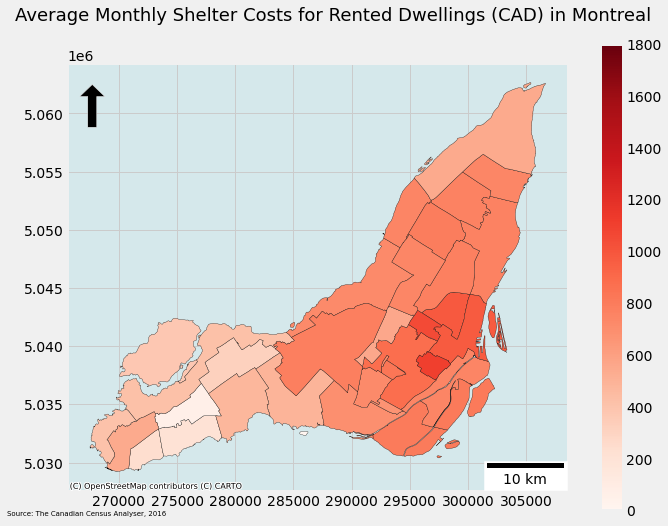

In [14]:
ax = mean_stats.plot(
    'HHTenant_Avg_Cost'
    ,figsize=(10,10)
    ,edgecolor="black"
    ,linewidth=0.3
    ,vmax=1800
    ,vmin=0
    ,legend=True
    ,legend_kwds= {'shrink':0.8}
    ,cmap="Reds"
)

ax.annotate(
    "Average Monthly Shelter Costs for Rented Dwellings (CAD) in Montreal",
    (0.53,1.09)
    ,xycoords = 'axes fraction'
    ,horizontalalignment='center'
    ,verticalalignment='bottom'
    ,fontsize = 18
    ,color='#000'
    ,fontstyle='normal'
)

plt.annotate('Source: The Canadian Census Analyser, 2016', (0,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)

background = db.query("city_id == 'ci122'")
cx.add_basemap(ax,
               crs=background.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=9, headwidth=25),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

scalebar = ScaleBar(1.5, dimension = 'si-length', units = 'm', location = 'lower right')

plt.gca().add_artist(scalebar)

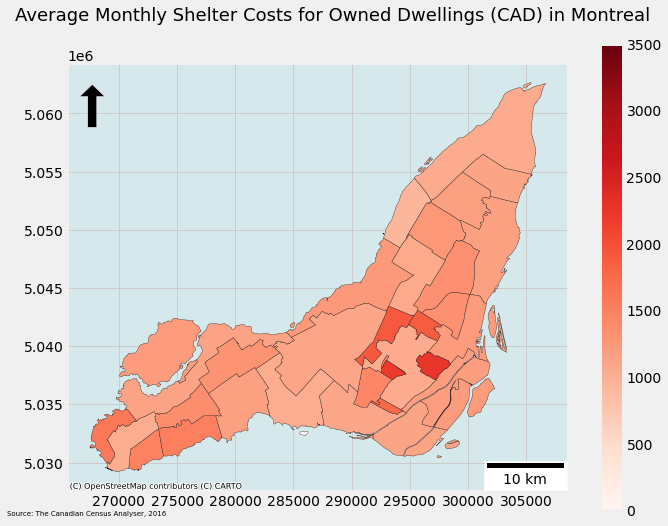

In [15]:
ax = mean_stats.plot(
    'HHOwner_Avg_Cost'
    ,figsize=(10,10)
    ,edgecolor="black"
    ,linewidth=0.3
    ,vmax=3500
    ,vmin=0
    ,legend=True
    ,legend_kwds= {'shrink':0.8}
    ,cmap="Reds"
)

ax.annotate(
    "Average Monthly Shelter Costs for Owned Dwellings (CAD) in Montreal",
    (0.53,1.09)
    ,xycoords = 'axes fraction'
    ,horizontalalignment='center'
    ,verticalalignment='bottom'
    ,fontsize = 18
    ,color='#000'
    ,fontstyle='normal'
)

plt.annotate('Source: The Canadian Census Analyser, 2016', (0,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)

background = db.query("city_id == 'ci122'")
cx.add_basemap(ax,
               crs=background.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=9, headwidth=25),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

scalebar = ScaleBar(1.5, dimension = 'si-length', units = 'm', location = 'lower right')

plt.gca().add_artist(scalebar)

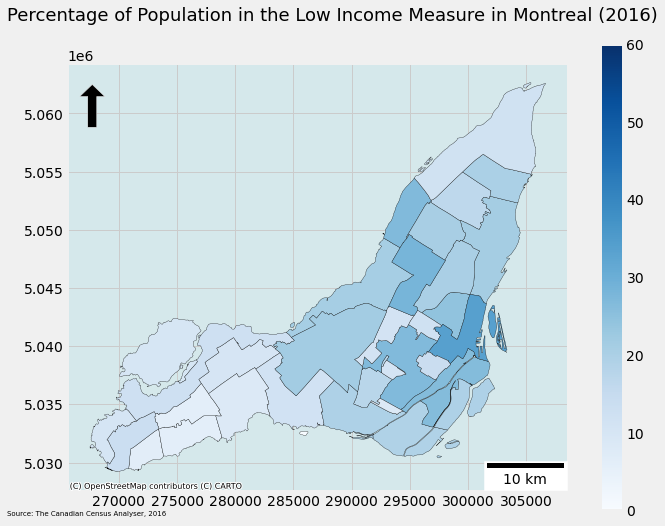

In [18]:
ax = sum_stats.plot(
    'LowIncPerc'
    ,figsize=(10,10)
    ,edgecolor="black"
    ,linewidth=0.3
    ,vmax=60
    ,vmin=0
    ,legend=True
    ,legend_kwds= {'shrink':0.8}
    ,cmap="Blues"
)

ax.annotate(
    "Percentage of Population in the Low Income Measure in Montreal (2016)",
    (0.53,1.09)
    ,xycoords = 'axes fraction'
    ,horizontalalignment='center'
    ,verticalalignment='bottom'
    ,fontsize = 18
    ,color='#000'
    ,fontstyle='normal'
)

plt.annotate('Source: The Canadian Census Analyser, 2016', (0,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)

background = db.query("city_id == 'ci122'")
cx.add_basemap(ax,
               crs=background.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=9, headwidth=25),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

scalebar = ScaleBar(1.5, dimension = 'si-length', units = 'm', location = 'lower right')

plt.gca().add_artist(scalebar)

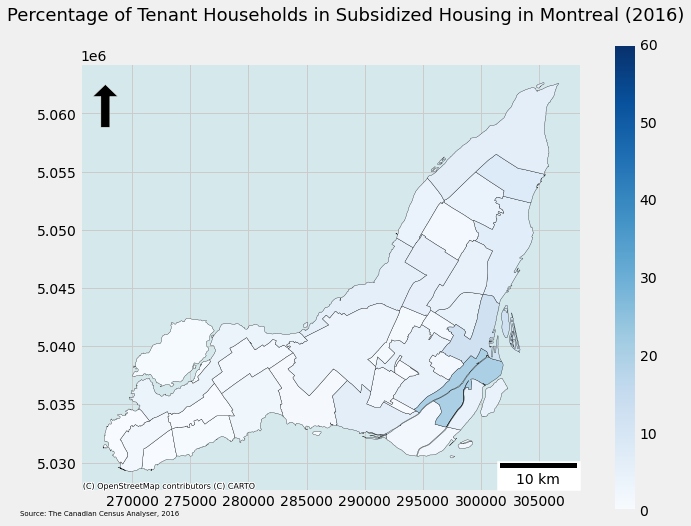

In [19]:
ax = mean_stats.plot(
    'HHTenant_Subsd'
    ,figsize=(10,10)
    ,edgecolor="black"
    ,linewidth=0.3
    ,vmax=60
    ,vmin=0
    ,legend=True
    ,legend_kwds= {'shrink':0.8}
    ,cmap="Blues"
)

ax.annotate(
    "Percentage of Tenant Households in Subsidized Housing in Montreal (2016)",
    (0.53,1.09)
    ,xycoords = 'axes fraction'
    ,horizontalalignment='center'
    ,verticalalignment='bottom'
    ,fontsize = 18
    ,color='#000'
    ,fontstyle='normal'
)

plt.annotate('Source: The Canadian Census Analyser, 2016', (0,0), (-60,-25), fontsize=7, 
             xycoords='axes fraction', textcoords='offset points', va='bottom')

data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)

background = db.query("city_id == 'ci122'")
cx.add_basemap(ax,
               crs=background.crs.to_string(),
               source=cx.providers.CartoDB.Voyager
              )

x, y, arrow_length = 0.05, 0.95, 0.1
ax.annotate('',xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=9, headwidth=25),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

scalebar = ScaleBar(1.5, dimension = 'si-length', units = 'm', location = 'lower right')

plt.gca().add_artist(scalebar)